### Structured Light

This example discusses helper functions and details for manipulating phase patterns: mainly regarding the contents of `slmsuite.holography.toolbox`. This tutorial can be run optionally with or without hardware connected. The below code block tries to load physical hardware and cleanly falls back to virtual hardware if loading fails. We also try to load the wavefront calibration from a previous tutorial. You'll need to set the exposure of the camera to get appropriate results.

In [1]:
# Header TODO: hide me with a tag.
# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision

pyglet not installed. Install to use ScreenMirrored SLMs.
PySpin not installed. Install to use FLIR cameras.
thorlabs.py: thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


In [2]:
from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

try:
    slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
    cam = AlliedVision(serial="02C5V", verbose=True, fliplr=True)
    fs = FourierSLM(cam, slm)
    fs.load_wavefront_calibration()
except:
    print("No hardware!")
    slm = SLM(width=1920, height=1200, bitdepth=8)
    cam = None

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


#### Simple Blazes & Lenses 

Linear phase ramps, also known as blazes after blazed gratings, are a useful analytic function for SLM usage. In this package, `slmsuite.holography.toolbox.blaze` implements this function. We can compute the blaze towards the direction of `vector`. This `vector` is in normalized $\frac{k_x}{k}$ units (see `slmsuite.holography.toolbox.convert_blaze_vector` for more information and unit conversions), and the `x_grid` and `y_grid` coordinates are likewise interpreted to be normalized to wavelength.

In [3]:
import slmsuite.holography.toolbox as toolbox

x_list = np.arange(2000)
y_list = np.arange(1000)
x_grid, y_grid = np.meshgrid(x_list, y_list)

blaze_phase = toolbox.blaze(grid=(x_grid, y_grid), vector=(.001, .001))

Then, we can render our result using `matplotlib`, with the aid of a quick helper function `plot_phase`:

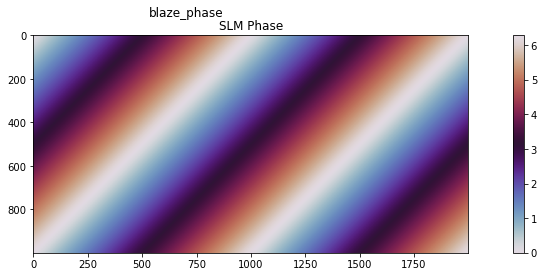

In [4]:
def plot_phase(phase, title="", cam=cam, zoom=True):
    # One plot if no camera; two otherwise.
    _, axs = plt.subplots(1, 2 - (cam is None), figsize=(16,4))

    if cam is None:
        axs = [axs]
    
    # Plot the phase.
    axs[0].set_title("SLM Phase")
    im = axs[0].imshow(
        np.mod(phase, 2*np.pi), 
        vmin=0,
        vmax=2*np.pi, 
        interpolation="none", 
        cmap="twilight"
    )
    plt.colorbar(im, ax=axs[0])
    
    # If a physical camera is provided, grab an image of the resulting pattern and plot.
    if cam is not None:
        slm.write(phase, settle=True)
        img = cam.get_image()

        axs[1].set_title("Camera Result")
        axs[1].imshow(img)
        if zoom:
            xlim = axs[1].get_xlim()
            ylim = axs[1].get_ylim()
            axs[1].set_xlim([xlim[0] * .75 + xlim[1] * .25, xlim[0] * .25 + xlim[1] * .75])
            axs[1].set_ylim([ylim[0] * .75 + ylim[1] * .25, ylim[0] * .25 + ylim[1] * .75])

    # Make a title, if given.
    plt.suptitle(title)
    plt.show()

plot_phase(blaze_phase, "blaze_phase", cam=None)

However, making and tracking `x_grid` and `y_grid` is an unwieldy pain. We encourage users to _not_ do this unless necessary and instead use convenience features builtin to `blaze` and similar toolbox functions. We can pass an SLM directly in place of the grids:

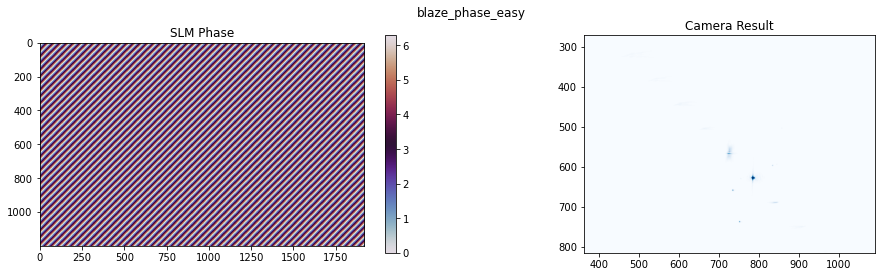

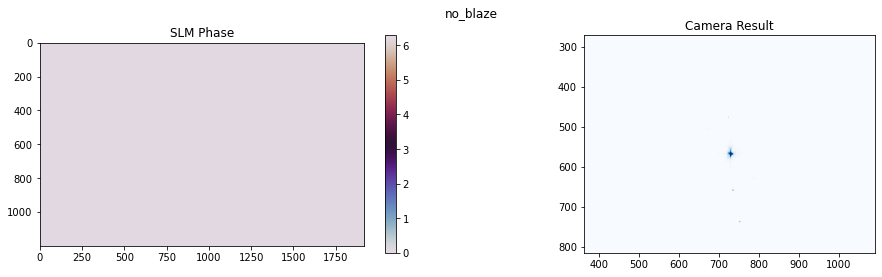

In [5]:
blaze_phase_easy = toolbox.blaze(grid=slm, vector=(.002, .002))
plot_phase(blaze_phase_easy, "blaze_phase_easy")
no_blaze = toolbox.blaze(grid=slm, vector=(0,0))
plot_phase(no_blaze, "no_blaze")

At startup, the SLM caches grids with appropriate `shape` and dimension, using the coordinates normalized to the target wavelength $(\frac{x}{\lambda}, \frac{y}{\lambda})$ which `blaze` expects. These grids are stored in `slm.x_grid` and `slm.x_grid`, and passing `grid=slm` is equivalent to passing `grid=(slm.x_grid, slm.y_grid)`.

Note that these grids are centered on the SLM, such that when we try other helper functions such as `slmsuite.holography.toolbox.lens`, the result is centered:

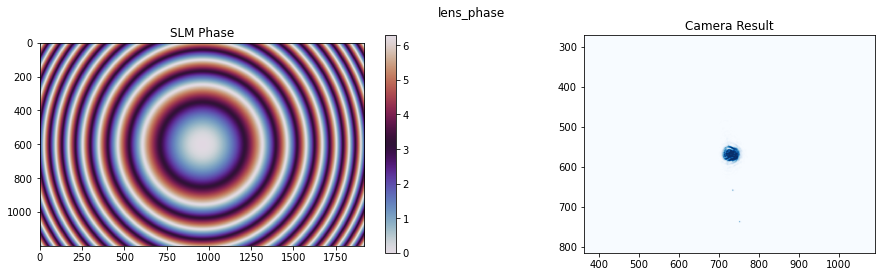

In [6]:
lens_phase = toolbox.lens(grid=slm, f=1e7)
plot_phase(lens_phase, "lens_phase")

As before, units are normalized to wavelength, so passing `f=1e7` is equivalent to requesting a lens with a focal length of ten million wavelengths, or 6.33 meters at 633 nm.

We can of course pass more interesting lenses. For instance, an elliptical lens:

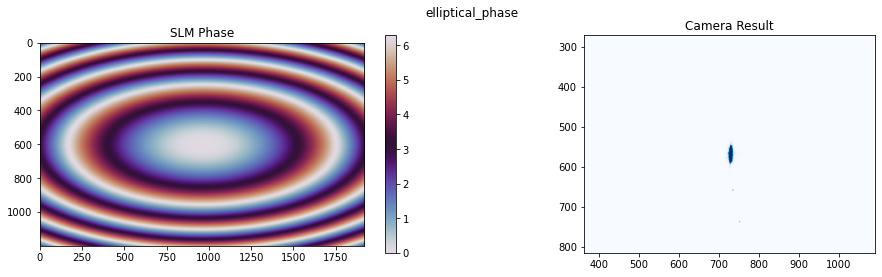

In [7]:
elliptical_phase = toolbox.lens(grid=slm, f=(5e7, 1e7))
plot_phase(elliptical_phase, "elliptical_phase")

Or going further to a cylindrical lens:

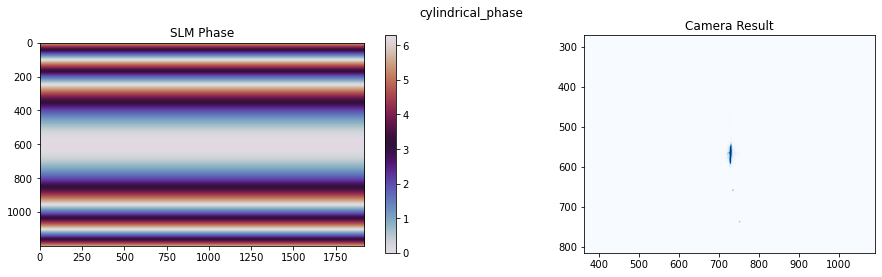

In [8]:
cylindrical_phase = toolbox.lens(grid=slm, f=(np.inf, 1e7))
plot_phase(cylindrical_phase, "cylindrical_phase")

Or rotate the lens about the center:

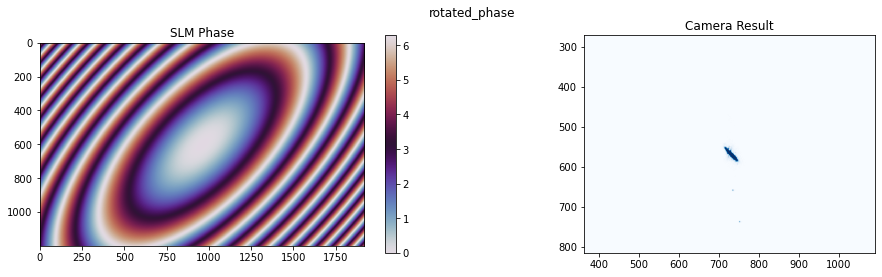

In [9]:
rotated_phase = toolbox.lens(grid=slm, f=(5e7, 1e7), angle=np.pi/4)
plot_phase(rotated_phase, "rotated_phase")

Or shift the center across the SLM. Note that center, like other parameters in `slmsuite` is in normalized units. Fortunately, the `slm` has helper variables `dx` and `dy` which store the pixel size in normalized units, such that requesting a `(800, -400)` pixel shift is as simple as multiplying by these variables to convert to normalized units:

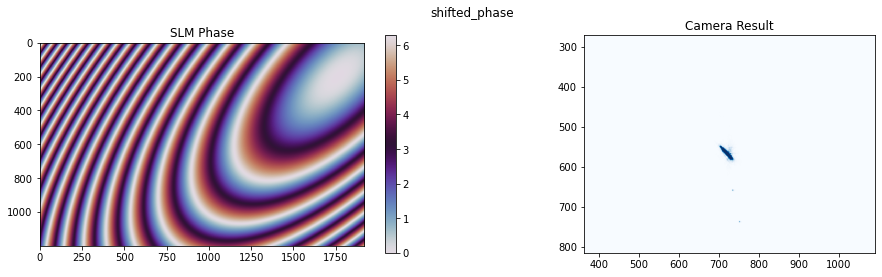

In [10]:
shifted_phase = toolbox.lens(grid=slm, f=(5e7, 1e7), center=(800*slm.dx, -400*slm.dy), angle=np.pi/4)
plot_phase(shifted_phase, "shifted_phase")

We can see a slight shift from the zero-th order, the expected result from the amount of blaze that is equivalent to shifting the lens on the SLM.

#### Structured Light Conversion

There are a number interesting optical modes whose farfield pattern is Gaussian in amplitude, with the addition of some phase. As the beam sourced on an SLM is often in a Gaussian mode, we can tune phase on the SLM to produce structured light in the nearfield of the camera. One example is a [Laguerre-Gaussian](https://en.wikipedia.org/wiki/Gaussian_beam#Laguerre-Gaussian_modes) mode, possessing the optical analog of [orbital angular momentum](https://en.wikipedia.org/wiki/Azimuthal_quantum_number). To start, we can take a look at the phase for a $LG_{lp} = LG_{10}$ mode, also known as a [vortex waveplate](https://en.wikipedia.org/wiki/Optical_vortex) (this pattern is hard to see on the camera because the resulting ring pattern is small):

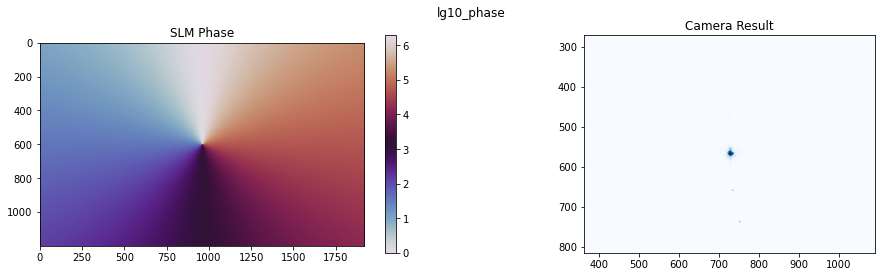

In [11]:
lg10_phase = toolbox.laguerre_gaussian(slm, l=1, p=0)
plot_phase(lg10_phase, "lg10_phase")

Higher order vortex phases such as the a $LG_{lp} = LG_{90}$ mode are easy to see on the camera:

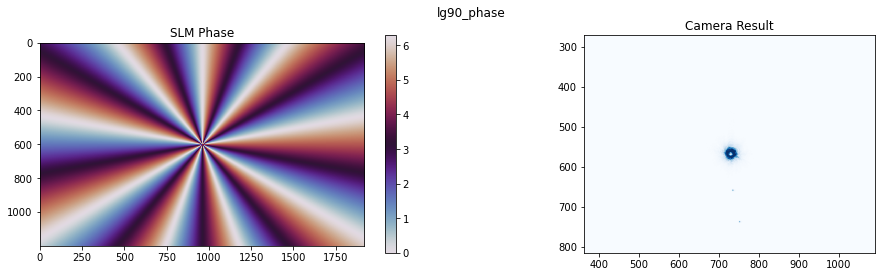

In [12]:
lg90_phase = toolbox.laguerre_gaussian(slm, l=9, p=0)
plot_phase(lg90_phase, "lg90_phase")

Higher order and more interesting modes are also possible, such as the $LG_{lp} = LG_{93}$ mode:

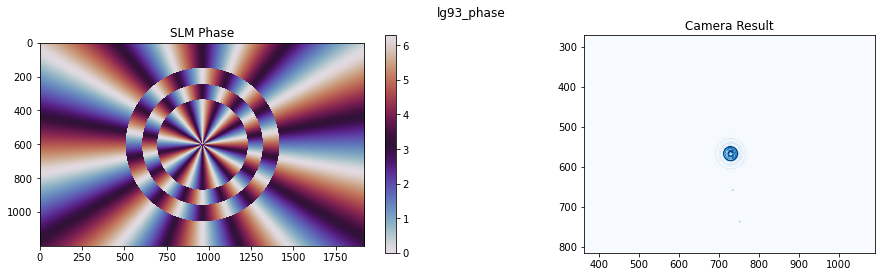

In [13]:
lg93_phase = toolbox.laguerre_gaussian(slm, l=9, p=3)
plot_phase(lg93_phase, "lg93_phase")

We can do cool things like shift the beam by adding a `blaze`.

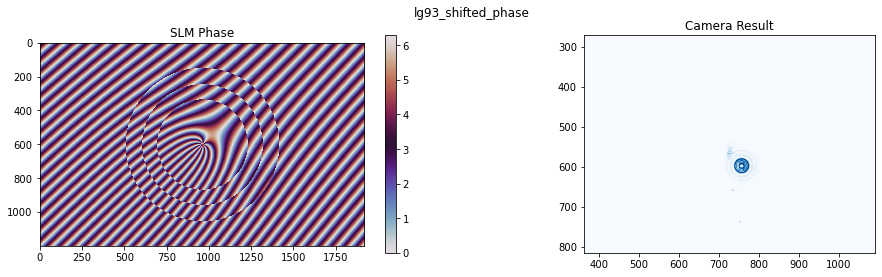

In [14]:
lg93_shifted_phase = lg93_phase + toolbox.blaze(grid=slm, vector=(.001, .001))
plot_phase(lg93_shifted_phase, "lg93_shifted_phase")

Or we can defocus the beam by adding a `lens`.

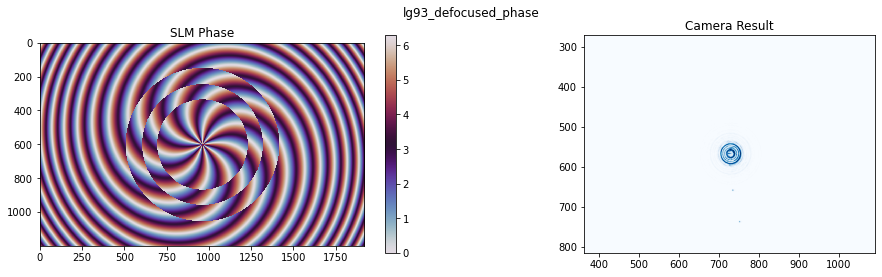

In [15]:
lg93_defocused_phase = lg93_phase + toolbox.lens(grid=slm, f=1e7)
plot_phase(lg93_defocused_phase, "lg93_defocused_phase")

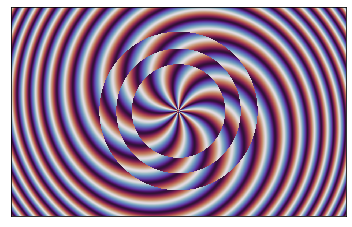

In [16]:
# Make a plot for the thumbnail.
plt.imshow(np.mod(lg93_defocused_phase, 2*np.pi), cmap='twilight', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

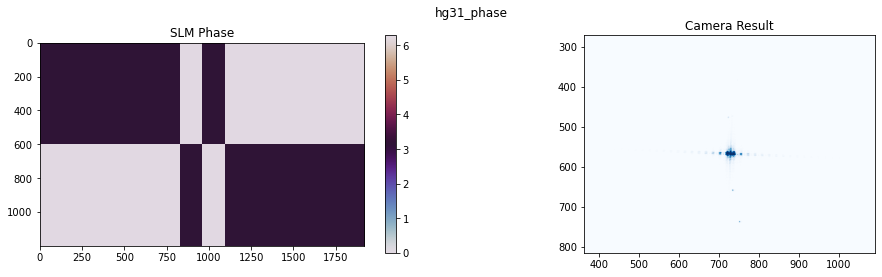

In [17]:
hg31_phase = toolbox.hermite_gaussian(grid=slm, n=3, m=1)
plot_phase(hg31_phase, "hg31_phase")

Although we admittedly haven't gotten around to implementing these yet, there are also `ince_gaussian` and `matheui_gaussian` beam conversions planned for `toolbox`. We welcome contributions if you want to finish these!

#### Segmented SLMs and `imprint`

In some cases, it is desirable to split an SLM into many individual regions. `slmsuite` has helper functions to support this.

The `slmsuite.toolbox.imprint()` operation 'imprints' a function such as `blaze` and `lens` from the previous section onto the SLM, but only in a given window. This window can be defined many ways (see API reference), but here we define it in `(x, w, y, h)` form. Extra keyword arguments to `imprint` are passed to the function. This function is used, for instance, to make the superpixels used for wavefront calibration. See the below examples for three superpixels producing three offset first order diffraction peaks, while most of the field and the zeroth order remain centered.

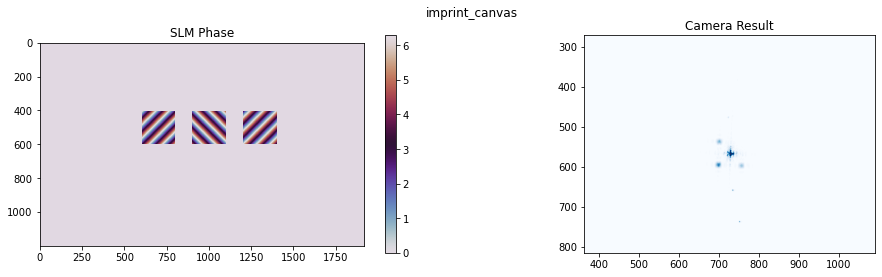

In [18]:
imprint_canvas = np.zeros(shape=slm.shape)

toolbox.imprint(imprint_canvas, window=[ 600, 200, 400, 200], function=toolbox.blaze, grid=slm, vector=(.001, .001))
toolbox.imprint(imprint_canvas, window=[ 900, 200, 400, 200], function=toolbox.blaze, grid=slm, vector=(-.001, .001))
toolbox.imprint(imprint_canvas, window=[1200, 200, 400, 200], function=toolbox.blaze, grid=slm, vector=(-.001, -.001))

plot_phase(imprint_canvas, "imprint_canvas")

`imprint()` supports two operation types:

- `imprint_operation="replace"`, the default, where the original phase on the `canvas` is overwritten, and
- `imprint_operation="add"`, where the original phase is instead added to.

As an example, phase in the middle window is zeroed, as the field had the negative of the imprinted phase. The right box adds to create a new vector.

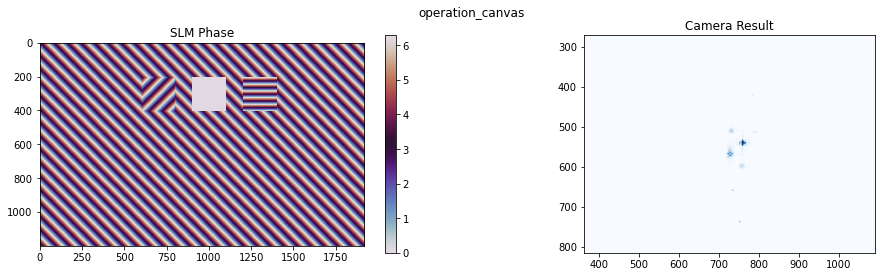

In [19]:
operation_canvas = toolbox.blaze(grid=slm, vector=(.001, -.001))

toolbox.imprint(operation_canvas,  [600, 200, 200, 200], function=toolbox.blaze, grid=slm, vector=(.001, .001), imprint_operation="replace")
toolbox.imprint(operation_canvas,  [900, 200, 200, 200], function=toolbox.blaze, grid=slm, vector=(-.001, .001), imprint_operation="add")
toolbox.imprint(operation_canvas, [1200, 200, 200, 200], function=toolbox.blaze, grid=slm, vector=(-.001, -.001), imprint_operation="add")

plot_phase(operation_canvas, "operation_canvas")

Now suppose we want to something more complicated, with very many regions on the same SLM instead of a handful. As an example, we can make an array of microlenses on a grid. First of all, we have helper functions to construct the grid. The function `toolbox.fit_affine()` can fit an affine transformation to three given vectors (`y0`, `y1`, `y2`), and return a grid of vectors with size `N`:

In [20]:
vectors = toolbox.fit_affine(y0=(200,100), y1=(300,110), y2=(220, 200), N=(14,9))

See the API reference of `toolbox.fit_affine()` for the full capabilities of the function. We can quickly visualize this to see we indeed have a grid:

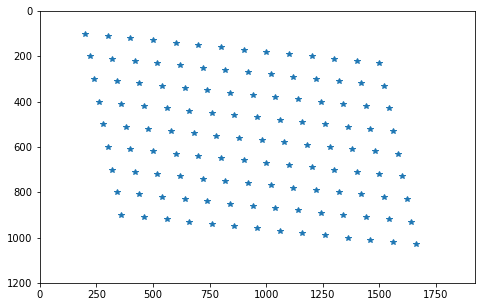

In [21]:
plt.figure(figsize=(10,5))
plt.plot(vectors[0,:], vectors[1,:], "*")
plt.xlim(0, slm.shape[1])
plt.ylim(slm.shape[0], 0)
plt.gca().set_aspect('equal')
plt.show()

Now we can use `imprint` to add a lens at each point. For now we'll use a width and height of `width = 50` pixels. We're also using the `centered` parameter of `imprint` such that the vector position of the window is `centered` instead of at the lower left corner.

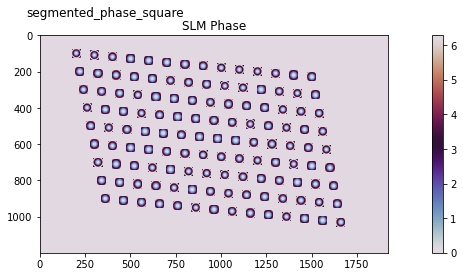

In [22]:
width = 50

def get_segmented_phase_square():
    N = vectors.shape[1]
    segmented_phase_square = np.zeros(shape=slm.shape)

    for x in range(N):
        vector_normalized = (   (vectors[0,x] - slm.shape[1]/2.) * slm.dx, 
                                (vectors[1,x] - slm.shape[0]/2.) * slm.dy   )
        toolbox.imprint(segmented_phase_square, [vectors[0,x], width, vectors[1,x], width], 
            function=toolbox.lens, grid=slm, f=np.random.uniform(5e4, 1e5), center=vector_normalized,
            centered=True)
    
    return segmented_phase_square

plot_phase(get_segmented_phase_square(), "segmented_phase_square", cam=None)

This is interesting, but we should try for better fill factor. We can use another helper
function `toolbox.get_smallest_distance()` and the Chebyshev metric $\max_i|u_i - v_i|$ to find the largest window
size that doesn't collide with other boxes.

Max width:  90.0


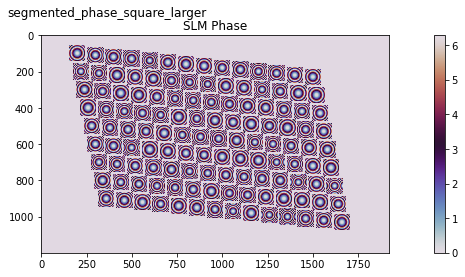

In [23]:
import scipy.spatial.distance as distance

width = toolbox.smallest_distance(vectors, metric=distance.chebyshev)
print("Max width: ", width)

plot_phase(get_segmented_phase_square(), "segmented_phase_square_larger", cam=None)

Better, but there's still some empty space that we might want to fill. The helper function `toolbox.get_voronoi_windows` can help with this, making a Voronoi cell around each point.

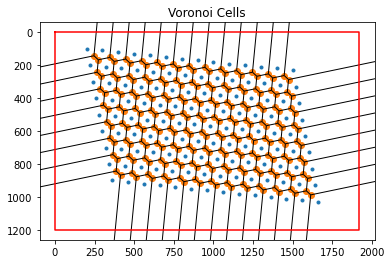

In [24]:
windows = toolbox.voronoi_windows(grid=slm.shape, vectors=vectors, plot=True)

This function returns a list of windows, where each window is a boolean array.

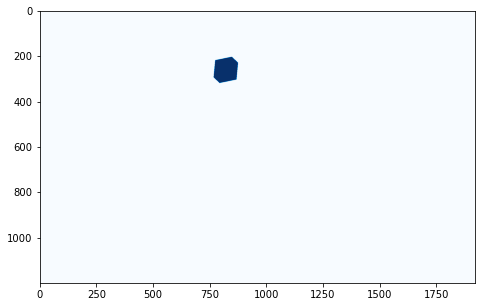

In [25]:
plt.figure(figsize=(10,5))
plt.imshow(windows[20])
plt.show()

Such windows can be passed to `imprint`, where the function will only be evaluated and imprinted within the defined area.

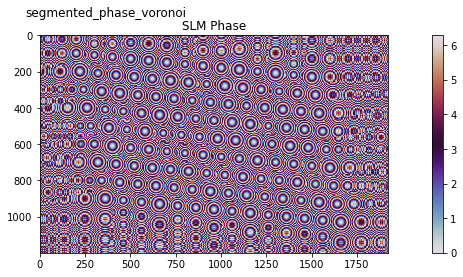

In [26]:
def get_segmented_phase():
    N = vectors.shape[1]
    segmented_phase = np.zeros(shape=slm.shape)

    for x in range(N):
        vector_normalized = (   (vectors[0,x] - slm.shape[1]/2.) * slm.dx, 
                                (vectors[1,x] - slm.shape[0]/2.) * slm.dy   )
        toolbox.imprint(segmented_phase, windows[x], 
            function=toolbox.lens, grid=slm, f=np.random.uniform(5e4, 1e5), center=vector_normalized)

    return segmented_phase

plot_phase(get_segmented_phase(), "segmented_phase_voronoi", cam=None)

As a final step, we can use the `radius=` parameter of `get_voronoi_windows()` clip the edge voronoi cells to more reasonable sizes around the lenses, again using `get_smallest_distance`.

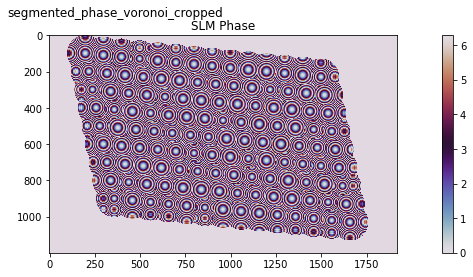

In [27]:
radius = toolbox.smallest_distance(vectors, metric=distance.euclidean)
windows = toolbox.voronoi_windows(grid=slm.shape, vectors=vectors, radius=radius, plot=False)

plot_phase(get_segmented_phase(), "segmented_phase_voronoi_cropped", cam=None)

#### Zernike Polynomials

[Zernike polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials) are orthogonal functions (usually defined on the unit disk) which are useful as a basis to model or correct aberration. For instance, the phase correction that we can calculate using wavefront calibration routines in `FourierSLM` can be represented as the sum of a small number of Zernike polynomials. 
The `zernike` function can be used to generate Zernike polynomials, as seen below for $Z_{nm} = Z_{20}$:

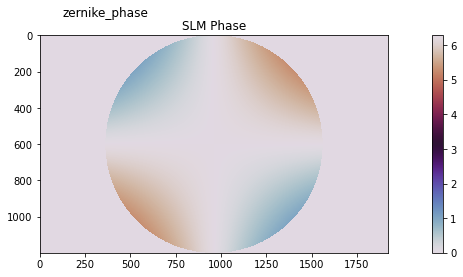

In [28]:
zernike_phase = toolbox.zernike(grid=slm, n=2, m=0, aperture="circular")
plot_phase(zernike_phase, "zernike_phase", cam=None)

The `zernike_sum` function handles summing these basis functions (in a resource-efficient way). We plot $Z_{20} - Z_{21} + Z_{31}$ below:

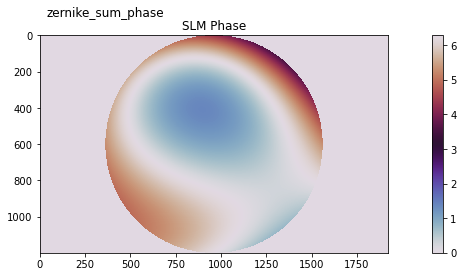

In [29]:
zernike_sum_phase = toolbox.zernike_sum(
    grid=slm, 
    weights=(   ((2, 0),  1),       # Z_20
                ((2, 1), -1),       # Z_21
                ((3, 1),  1)    ),  # Z_31
    aperture="circular"
)
plot_phase(zernike_sum_phase, "zernike_sum_phase", cam=None)

Zernike polynomials are canonically defined on a circular aperture. However, we may
want to use these polynomials on other apertures (e.g. a rectangular SLM).
Cropping this aperture breaks the orthogonality and normalization of the set, but
this is fine for many applications. While it is possible to orthonormalize the
cropped set, we do not do so in `slmsuite`, as this is not critical for target
applications such as aberration correction. Requesting a `"cropped"` aperture 
circumscribes the shape of the SLM with the circle of the Zernike disk.

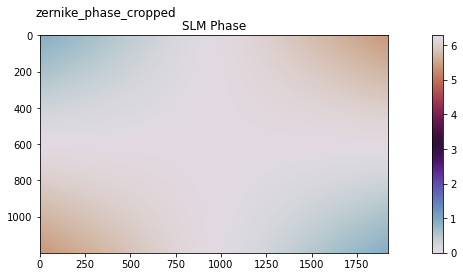

In [30]:
zernike_phase_cropped = toolbox.zernike(grid=slm, n=2, m=0, aperture="cropped")
plot_phase(zernike_phase_cropped, "zernike_phase_cropped", cam=None)

We also support a stretched `"elliptical"` aperture, where
the Zernike disk is scaled anisotropically until each cartesian pupil edge touches a grid
edge.

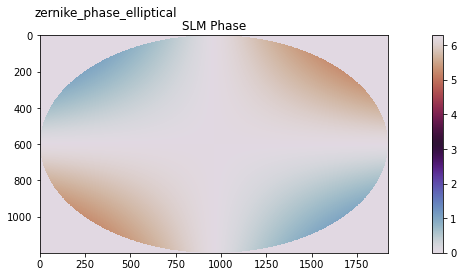

In [31]:
zernike_phase_elliptical = toolbox.zernike(grid=slm, n=2, m=0, aperture="elliptical")
plot_phase(zernike_phase_elliptical, "zernike_phase_elliptical", cam=None)